In [29]:
import pandas as pd
import openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False ## 마이나스 '-' 표시 제대로 출력
 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [30]:
# get Data file
file_path = '../data/output/특정품목 조달 내역_2022.xlsx'
data = pd.read_excel(file_path, index_col=0)
print(data.head(5))

  수요기관지역명 수요기관구분      장비금액       계약금액    냉방용량    난방용량         날짜
0     경기도    지자체   1502000    6758800    18.4    20.7 2022-01-21
1     경기도    지자체   6367000   23828260    62.9    70.9 2022-04-18
2   서울특별시    지자체   7570000   30011200    75.5    85.6 2022-01-26
3     경기도   교육기관  41502960  218391150  1054.9  1183.7 2022-02-15
4   서울특별시    지자체   3662000   30120750    47.2    52.9 2022-05-04


In [31]:
# make new columns
data['용량'] = data[['냉방용량','난방용량']].max(axis=1)

# delete the row with the 0 cost
data = data[data['계약금액'] != 0]
data = data[data['장비금액'] != 0]
data = data[data['용량'] != 0]

# make new columns
data['장비금액비율'] = data['장비금액']/data['계약금액']

# calculate the lower and upper bounds based on the specified quantile value
q1 = data['용량'].quantile(0.25)
q3 = data['용량'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

In [32]:
# filter out the outlier rows
data = data[(data['용량'] >= lower_bound) & (data['용량'] <= upper_bound)]
print(data.head(5))


   수요기관지역명 수요기관구분     장비금액      계약금액  냉방용량  난방용량         날짜    용량    장비금액비율
0      경기도    지자체  1502000   6758800  18.4  20.7 2022-01-21  20.7  0.222229
1      경기도    지자체  6367000  23828260  62.9  70.9 2022-04-18  70.9  0.267204
2    서울특별시    지자체  7570000  30011200  75.5  85.6 2022-01-26  85.6  0.252239
4    서울특별시    지자체  3662000  30120750  47.2  52.9 2022-05-04  52.9  0.121577
11   서울특별시    지자체  4550000  18645680  40.8  45.7 2022-04-21  45.7  0.244024


In [33]:
# create a linear regression model
reg = LinearRegression().fit(data[['용량']], data['계약금액'])

# use statsmodels to identify influential points
influence = sm.OLS(data['계약금액'], sm.add_constant(data['용량'])).fit().get_influence()
outliers = influence.summary_frame().loc[influence.summary_frame().cooks_d > 4/len(data)]

# remove the influential points from the dataframe
data_copy = data.drop(outliers.index)

# re-fit the linear regression model without the influential points
reg = LinearRegression().fit(data_copy[['용량']], data_copy['계약금액'])

# print the coefficients
print('Intercept:', reg.intercept_)
print('Coefficient:', reg.coef_[0])

Intercept: 780335.6792450566
Coefficient: 242487.13213253286


In [37]:
%matplotlib widget
# plot the scatter plot and linear regression line
fig, ax = plt.subplots()
ax.scatter(data['용량'], data['계약금액'], color='blue')
ax.plot(data['용량'], reg.predict(data[['용량']]), color='red')
ax.set_xlabel('Capacity(kW)')
ax.set_ylabel('Total Cost(KRW)')
ax.set_title('Scatter plot with linear regression line')
plt.show()

KeyError: 'module'

In [35]:
# create a linear regression model
reg = LinearRegression().fit(data[['용량']], data['장비금액비율'])

# use statsmodels to identify influential points
influence = sm.OLS(data['장비금액비율'], sm.add_constant(data['용량'])).fit().get_influence()
outliers = influence.summary_frame().loc[influence.summary_frame().cooks_d > 4/len(data)]

# remove the influential points from the dataframe
data_copy = data.drop(outliers.index)

# re-fit the linear regression model without the influential points
reg = LinearRegression().fit(data_copy[['용량']], data_copy['장비금액비율'])

# print the coefficients
print('Intercept:', reg.intercept_)
print('Coefficient:', reg.coef_[0])

Intercept: 0.6696024345567093
Coefficient: -0.0030788079202125444


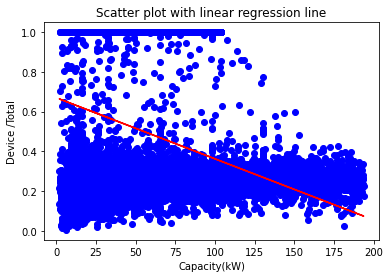

In [36]:
%matplotlib widget
# plot the scatter plot and linear regression line
fig, ax = plt.subplots()
ax.scatter(data_copy['용량'], data_copy['장비금액비율'], color='blue')
ax.plot(data_copy['용량'], reg.predict(data_copy[['용량']]), color='red')
ax.set_xlabel('Capacity(kW)')
ax.set_ylabel('Device /Total')
ax.set_title('Scatter plot with linear regression line')
plt.show()